In [1]:
import numpy as np
import scipy.io

# Load DEAP dataset (Change path accordingly)
data_path = "/kaggle/input/deap-matlab/"
subject_data = []

# Load all 32 subjects
for i in range(1, 33):
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    subject_data.append(mat["data"])  # Shape: (40 trials, 32 channels, 8064 samples)

# Convert list to NumPy array (Subjects × Trials × Channels × Samples)
subject_data = np.array(subject_data)

In [2]:
print("Subject Data Shape: ",subject_data.shape)

Subject Data Shape:  (32, 40, 40, 8064)


In [3]:
import scipy.io
import numpy as np

# Path to DEAP dataset
data_path = "/kaggle/input/deap-matlab/"
subject_labels = []

# Load labels for all subjects
for i in range(1, 33):  # 32 subjects
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    subject_labels.append(mat["labels"])  # Shape: (40 trials, 4)

# Convert to NumPy array: (32 subjects, 40 trials, 4 labels)
subject_labels = np.array(subject_labels)

In [4]:
def get_emotion_labels(labels):
    """Convert valence-arousal scores into categorical emotion labels."""
    valence, arousal = labels[:, 0], labels[:, 1]

    # Convert to binary (High = 1, Low = 0)
    valence_labels = (valence >= 5).astype(int)
    arousal_labels = (arousal >= 5).astype(int)

    # Define emotion categories (0-3)
    emotion_labels = 2 * valence_labels + arousal_labels
    return emotion_labels

# Apply function to all subjects
subject_emotions = np.array([get_emotion_labels(subject) for subject in subject_labels])  # Shape: (32, 40)


In [5]:
print("Emotion Data Shape: ",subject_emotions.shape)

Emotion Data Shape:  (32, 40)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


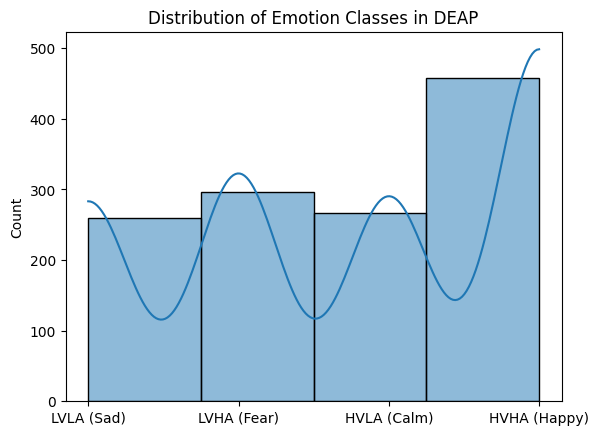

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all labels
all_labels = subject_emotions.flatten()

# Plot distribution
sns.histplot(all_labels, bins=4, kde=True)
plt.xticks([0, 1, 2, 3], ["LVLA (Sad)", "LVHA (Fear)", "HVLA (Calm)", "HVHA (Happy)"])
plt.title("Distribution of Emotion Classes in DEAP")
plt.show()

In [7]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, low=4, high=45, fs=128, order=4):
    nyquist = 0.5 * fs
    low, high = low / nyquist, high / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=-1)


In [8]:
def differential_entropy(signal):
    """Calculate Differential Entropy (DE) for an EEG signal."""
    variance = np.var(signal)
    return 0.5 * np.log2(2 * np.pi * np.e * variance)

# Frequency bands
freq_bands = {"Delta": (1, 4), "Theta": (4, 8), "Alpha": (8, 14), "Beta": (14, 30), "Gamma": (31, 50)}

# Extract DE features
num_subjects, num_trials, num_channels, num_samples = subject_data.shape
segment_length = 128  # 1-second window

de_features = []
for subject in subject_data:
    subject_features = []
    for trial in subject:
        trial_features = []
        for start in range(0, num_samples, segment_length):
            segment = trial[:, start:start + segment_length]
            band_features = []
            for band, (low, high) in freq_bands.items():
                band_segment = bandpass_filter(segment, low, high)
                band_features.append(np.apply_along_axis(differential_entropy, axis=-1, arr=band_segment))
            trial_features.append(np.concatenate(band_features, axis=0))
        subject_features.append(np.array(trial_features))
    de_features.append(np.array(subject_features))

# Convert list to NumPy array
de_features = np.array(de_features)

In [9]:
print("DE features Shape: ",de_features.shape)

DE features Shape:  (32, 40, 63, 200)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class CommonFeatureExtractor(nn.Module):
    """Extracts common features from EEG signals"""
    def __init__(self, input_dim=200, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

class SubjectSpecificFeatureExtractor(nn.Module):
    """Extracts subject-specific features from common features"""
    def __init__(self, input_dim=64, output_dim=32):
        super(SubjectSpecificFeatureExtractor, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = nn.LeakyReLU()

    def forward(self, x):
        return self.activation(self.fc(x))

class SubjectClassifier(nn.Module):
    """Classifies emotions based on extracted features"""
    def __init__(self, input_dim=32, num_classes=3):
        super(SubjectClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [11]:
import torch.nn.functional as F

def contrastive_loss(anchor, positive, negative, margin=1.0):
    """Computes contrastive loss to pull similar EEG features together and push dissimilar apart."""
    pos_dist = torch.norm(anchor - positive, p=2, dim=1)
    neg_dist = torch.norm(anchor - negative, p=2, dim=1)
    return torch.mean(F.relu(pos_dist - neg_dist + margin))

class GeneralizedCrossEntropy(nn.Module):
    """Generalized Cross-Entropy (GCE) Loss to handle noisy labels"""
    def __init__(self, q=0.55):
        super(GeneralizedCrossEntropy, self).__init__()
        self.q = q

    def forward(self, pred, labels):
        pred = torch.softmax(pred, dim=1)  # Ensure probability distribution

        # Ensure labels are of shape (batch_size, 1)
        if labels.dim() == 1:  # If labels are (batch_size,)
            labels = labels.unsqueeze(1)  # Convert to (batch_size, 1)
        
        # Ensure labels are Long type for gather() operation
        labels = labels.long()

        # Fix: Ensure labels are within bounds of num_classes
        num_classes = pred.shape[1]
        labels = labels.clamp(0, num_classes - 1)  # Prevent out-of-bounds index error

        # Compute GCE Loss
        loss = (1 - pred.gather(1, labels) ** self.q) / self.q
        return loss.mean()

In [15]:
# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfe = CommonFeatureExtractor().to(device)
sfe = SubjectSpecificFeatureExtractor().to(device)
classifier = SubjectClassifier().to(device)
criterion = GeneralizedCrossEntropy()
optimizer = optim.Adam(list(cfe.parameters()) + list(sfe.parameters()) + list(classifier.parameters()), lr=0.01)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    for subject in range(32):
        for trial in range(40):
            X = torch.tensor(de_features[subject, trial], dtype=torch.float32).to(device)
            y = torch.tensor(subject_emotions[subject, trial], dtype=torch.long).to(device)  # Ensure labels are long
            
            if y.dim() == 0:  # If label is scalar, convert to tensor
                y = y.unsqueeze(0)  # Convert to shape (1,)

            optimizer.zero_grad()
            common_features = cfe(X)
            subject_features = sfe(common_features)
            predictions = classifier(subject_features)

            loss = criterion(predictions, y)  # Now correctly shaped labels
            loss.backward()
            optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: nan
Epoch 2/50, Loss: nan
Epoch 3/50, Loss: nan
Epoch 4/50, Loss: nan
Epoch 5/50, Loss: nan
Epoch 6/50, Loss: nan
Epoch 7/50, Loss: nan
Epoch 8/50, Loss: nan
Epoch 9/50, Loss: nan
Epoch 10/50, Loss: nan
Epoch 11/50, Loss: nan
Epoch 12/50, Loss: nan
Epoch 13/50, Loss: nan
Epoch 14/50, Loss: nan
Epoch 15/50, Loss: nan
Epoch 16/50, Loss: nan
Epoch 17/50, Loss: nan
Epoch 18/50, Loss: nan
Epoch 19/50, Loss: nan
Epoch 20/50, Loss: nan
Epoch 21/50, Loss: nan
Epoch 22/50, Loss: nan
Epoch 23/50, Loss: nan
Epoch 24/50, Loss: nan
Epoch 25/50, Loss: nan
Epoch 26/50, Loss: nan
Epoch 27/50, Loss: nan
Epoch 28/50, Loss: nan
Epoch 29/50, Loss: nan
Epoch 30/50, Loss: nan
Epoch 31/50, Loss: nan
Epoch 32/50, Loss: nan
Epoch 33/50, Loss: nan
Epoch 34/50, Loss: nan
Epoch 35/50, Loss: nan
Epoch 36/50, Loss: nan
Epoch 37/50, Loss: nan
Epoch 38/50, Loss: nan
Epoch 39/50, Loss: nan
Epoch 40/50, Loss: nan
Epoch 41/50, Loss: nan
Epoch 42/50, Loss: nan
Epoch 43/50, Loss: nan
Epoch 44/50, Loss: n

In [13]:
from sklearn.metrics import accuracy_score

def evaluate_model():
    y_pred, y_true = [], []
    with torch.no_grad():
        for subject in range(32):
            for trial in range(40):
                X = torch.tensor(de_features[subject, trial], dtype=torch.float32).to(device)
                
                # Ensure y is an integer tensor
                y = subject_emotions[subject, trial]  # Use preprocessed emotion labels
                
                # Ensure y is a 1D numpy array
                if isinstance(y, np.ndarray):
                    y = int(y)  # Convert to scalar if necessary

                pred = classifier(sfe(cfe(X)))
                pred_label = torch.argmax(pred, dim=1).cpu().numpy().flatten()[0]  # Extract scalar

                y_pred.append(pred_label)  # Store single integer
                y_true.append(y)  # Store single integer

    # Convert to NumPy arrays for sklearn
    y_pred = np.array(y_pred, dtype=int)
    y_true = np.array(y_true, dtype=int)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2%}")

evaluate_model()


Accuracy: 20.31%


In [16]:
import json
import os

def ipynbtopyParse(fileIn,fileOut):

    with open(fileIn) as json_file:
        data = json.load(json_file)
    
    out = open(fileOut,"w")
    
    for cell in data['cells']:    
        if (cell.get('cell_type')!=None and cell.get('cell_type')=='markdown'):
            lines = cell.get('source')
            if len(lines)>0:
                out.write("# "+str(lines[0]).replace("#", ''))
                out.write("\n")
        if (cell.get('cell_type')!=None and cell.get('cell_type')=='code'):
            for line in cell.get('source'):
                out.write(line)
            out.write("\n\n")
        # out.write("\n")
            
    out.close()


def ipynbtopy(input_dir):
    for dirname, dirnames, filenames in os.walk(input_dir):
        # print path to all subdirectories first.
        # for subdirname in dirnames:
        #     print(os.path.join(dirname, subdirname))
    
        # print path to all filenames.
        for filename in filenames:
            if filename.endswith(".ipynb"):
                newfilename = filename[:-6]+".py"
                newdirname = dirname+r"\pysrc"
                if not os.path.exists(newdirname):
                    os.mkdir(newdirname)
                ipynbtopyParse(os.path.join(dirname, filename),os.path.join(newdirname, newfilename))
                
        # Advanced usage:
        # editing the 'dirnames' list will stop os.walk() from recursing into there.
        if '.git' in dirnames:
            # don't go into any .git directories.
            dirnames.remove('.git')
        if '.ipynb_checkpoints' in dirnames:
            # don't go into any .git directories.
            dirnames.remove('.ipynb_checkpoints')

input_dir="."
ipynbtopy(input_dir)